## 1 Stock Step Down 상품 평가하기

In [8]:
# 주말 제외한 6개월마다의 날짜 생성
import pandas as pd 

D0=pd.date_range('2025-12-10',periods=6,freq='6BMS') 
D0

DatetimeIndex(['2026-01-01', '2026-07-01', '2027-01-01', '2027-07-01',
               '2028-01-03', '2028-07-03'],
              dtype='datetime64[ns]', freq='6BMS')

In [10]:
# 대한민국의 달력기준으로 데이터 만들기
import holidays # 별도로 설치하여야 함

# 주말을 제외한 대한민국의 휴일 정보를 가져온다. 
kor_holidays=list(holidays.KOR(years=range(2025,2029)).keys()) #list()데이터로 변환
kor_holidays=pd.to_datetime(kor_holidays) # 데이터프레임 날짜로 변환

# Business days로 6개의 날짜 생성
D_samples=pd.date_range('2025-12-10',periods=6,freq='6BMS') 

# 생성된 날짜에서 대한민국 휴일 제외
# 아래에서 사용된 isin()은 존재하는지를 확인하는 내장함수
D0=D_samples[~D_samples.isin(kor_holidays)] # 휴일정보에 포함되지 않는 날짜만 추출
D0

DatetimeIndex(['2026-07-01', '2027-07-01', '2028-01-03', '2028-07-03'], dtype='datetime64[ns]', freq=None)

In [12]:
import pandas as pd
import holidays
from datetime import datetime

# 대한민국 공휴일 불러오기
kor_holidays = list(holidays.KOR(years=range(2025, 2031)).keys())
kor_holidays = pd.to_datetime(kor_holidays)

# 오늘 날짜
today = pd.to_datetime(datetime.today().date())
six_months_later = today + pd.DateOffset(months=6)

# 6개월마다의 기준일 생성
month_starts = pd.date_range(start=six_months_later, periods=6, freq='6MS')

# 각 기준일에서 해당 월의 첫 번째 영업일(공휴일 제외) 추출
business_days = []
for dt in month_starts:
    # 시작 날짜부터 한 달간의 영업일 추출
    month_range = pd.date_range(start=dt, end=dt + pd.offsets.MonthEnd(0), freq='B')
    # 영업일이 대한민국의 휴일이 아닌 것을 다시 추출출
    valid_days = [d for d in month_range if d not in kor_holidays]
    if valid_days: # 자료가 있다면
        business_days.append(valid_days[0])

# 결과 출력
print(business_days)


[Timestamp('2026-02-02 00:00:00'), Timestamp('2026-08-03 00:00:00'), Timestamp('2027-02-01 00:00:00'), Timestamp('2027-08-02 00:00:00'), Timestamp('2028-02-01 00:00:00'), Timestamp('2028-08-01 00:00:00')]


In [4]:
from datetime import datetime

# 날짜 차이 계산 (단위: 일수)
days_diff = [(d - today).days for d in business_days]

# DataFrame 생성
df = pd.DataFrame({
    '영업일': [d.strftime('%Y-%m-%d') for d in business_days],
    '오늘까지 남은 일수': days_diff})
df

,영업일,오늘까지 남은 일수
0,2026-02-02,208
1,2026-08-03,390
2,2027-02-01,572
3,2027-08-02,754
4,2028-02-01,937
5,2028-08-01,1119


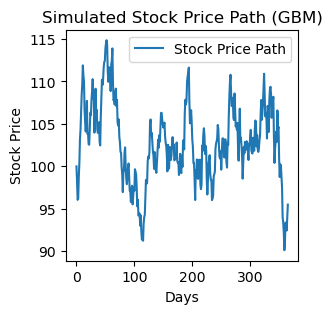

In [13]:
# 시뮬레이션 횟수 만큼 주가 생성하기
import numpy as np 
import matplotlib.pyplot as plt

# 주가 경로 생성
N=365 # 만기까지의 날짜수
sim=1000 # 시뮬레이션 회수
r,sigma=0.05, 0.3
dt=1/365

np.random.seed(111)
W = np.random.randn(N,sim)  # 표준 정규분포 난수

# log(S) 행렬 만들기
lnS=(r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * W

# 앞에 붙이기
lnS = np.insert(lnS,0,np.log(100), axis=0)
# 누적합 구하기
S=np.exp(np.cumsum(lnS,axis=0))

# 첫번째 시뮬레이션 결과 시각화
plt.figure(figsize=(3,3))
plt.plot(S[:,0], label="Stock Price Path")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("Simulated Stock Price Path (GBM)")
plt.legend()
plt.show()

In [14]:
def SD_lstar_CPU(S, kijun, K, T, c, r, q, sigma, barrier, dummy, sim):
    import numpy as np
    from scipy.stats import norm
    
    """
    ELS (Equity-Linked Securities) 조기상환 및 만기상환 시뮬레이션
    
    Parameters:
    - S: 초기 주가
    - kijun: 기준 가격
    - K: 행사가격
    - T: 옵션 만기 (일 단위)
    - c: 조기상환 행사가 (0.01 이상)
    - r: 무위험 이자율
    - q: 배당률
    - sigma: 변동성
    - barrier: 배리어 (예: 65% 미만일 경우 지급)
    - dummy: 배리어 이벤트 여부 (0 또는 1)
    - sim: 시뮬레이션 횟수
    
    Returns:
    - mu: 최종 가격의 정규분포 적합 결과 (평균, 표준편차)
    """

 
    
    # 주가 경로 생성
    N=T[-1] # 만기까지의 날짜수
    np.random.seed(111)
    W = np.random.randn(N,sim)  # 표준 정규분포 난수
    dt=1/365
    
    # log(S) 행렬 만들기
    lnS=(r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * W

    # 앞에 붙이기
    lnS = np.insert(lnS,0,np.log(S), axis=0)
    # 누적합 구하기
    S=np.exp(np.cumsum(lnS,axis=0))

     # 수익률 행렬 변환
    R = S / kijun

    Price = np.zeros(sim)  # 최종 옵션 가격 배열

    EN=len(K) # 조기상환 회차수 
    for i in range(EN):
        out = np.where((Price == 0) & (R[T[i], :] >= K[i]))  # 아직 상환되지 않은 경우만 선택
        # 조기상환된 경우 가격 업데이트
        Price[out] = 10000 * (1 + c[i]) * np.exp(-r * (T[i]) / 365)
   
    # 만기상환 테스트
    check = np.where(Price == 0) # 아직 상환되지 않은 경우의 인덱스 추출

    # 만기 손실 체크 
    for idx in check:
        if np.min(R[:,idx]) < barrier: # 해당 sim 회차의 최소값이 배리어 미만이면?
            # 배리어 하외 하면 R값으로 리턴
            Price[idx] = 10000 * (R[-1, idx]) * np.exp(-r * T[-1]/365)
        else: # 배리어를 한번도 친적이 없으면 마지막 쿠폰 지급
            Price[idx] = 10000 * (1 + dummy) * np.exp(-r * T[-1]/365)
    
    # 정규분포 적합
    mu, s = norm.fit(Price)

    return mu

In [15]:
# 스텝다운 상품 평가 정보
S0=100
kijun=100
r=0.035
q=0
sigma, barrier, dummy, sim=0.3, 0.65, 0.132,10000
K=[0.95,0.95,0.95,0.90,0.90,0.85]
T=np.array(df['오늘까지 남은 일수'])
c=np.array([1,2,3,4,5,6])*0.022

SD_lstar_CPU(S0, kijun, K, T, c, r, q, sigma, barrier, dummy, sim)

9138.554539095841

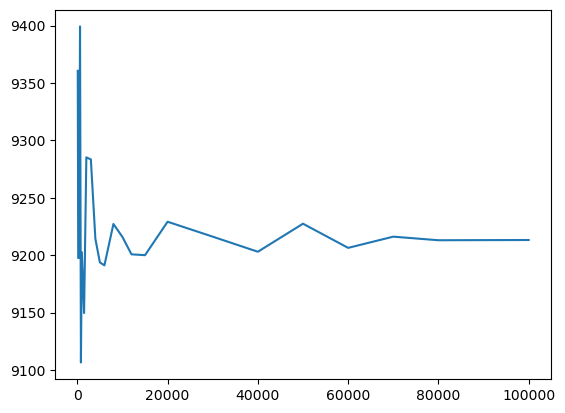

In [53]:
Sims=[100,200,400,600,800,1000,1500,2000,3000,4000,
      5000,6000,8000,10000,12000,15000,20000,30000,
     40000,50000,60000,70000,80000,100000]
Price_Sims=[]
for sim in Sims:
    res=SD_lstar_CPU(S, kijun, K, T, c, r, q, sigma, barrier, dummy, sim)
    Price_Sims.append(res)

plt.plot(Sims,Price_Sims)

In [17]:
def SD_lstar_GPU(S, kijun, K, T, c, r, q, sigma, barrier, dummy, sim):
    import cupy as cp
    from scipy.stats import norm  # 정규분포 적합은 여전히 CPU에서 수행

    """
    ELS (Equity-Linked Securities) 조기상환 및 만기상환 시뮬레이션 (GPU 버전)
    """

    N = T[-1]  # 전체 만기까지의 날짜 수
    dt = 1 / 365  # 하루 단위
    cp.random.seed(111)
    W = cp.random.randn(N, sim)  # 표준 정규분포 난수 생성

    # 로그 수익률 경로 생성
    lnS = (r - 0.5 * sigma**2) * dt + sigma * cp.sqrt(dt) * W

    # 시작값 log(S)를 앞에 추가
    lnS = cp.concatenate([cp.full((1, sim), cp.log(S)), lnS], axis=0)

    # 누적합 후 지수화하여 주가 경로 생성
    S_path = cp.exp(cp.cumsum(lnS, axis=0))

    # 수익률 행렬 계산
    R = S_path / kijun

    # 초기 옵션 가격 배열
    Price = cp.zeros(sim)

    EN = len(K)
    for i in range(EN):
        cond = (Price == 0) & (R[T[i], :] >= K[i])
        Price = cp.where(cond, 10000 * (1 + c[i]) * cp.exp(-r * T[i] / 365), Price)

    # 아직 상환되지 않은 시뮬레이션 찾기
    check = (Price == 0)

    # 배리어 하회 여부 확인
    min_R = cp.min(R, axis=0)
    barrier_hit = (min_R < barrier) & check
    no_barrier_hit = ~barrier_hit & check

    # 배리어 하회한 경우
    Price = cp.where(barrier_hit, 10000 * R[-1, :] * cp.exp(-r * T[-1] / 365), Price)

    # 배리어를 한 번도 안 맞은 경우
    Price = cp.where(no_barrier_hit, 10000 * (1 + dummy) * cp.exp(-r * T[-1] / 365), Price)

    # GPU에서 CPU로 데이터 이동하여 정규분포 적합
    Price_cpu = cp.asnumpy(Price)
    mu, s = norm.fit(Price_cpu)

    return mu


In [18]:
import numpy as np
# 스텝다운 상품 평가 정보
S=100
kijun=100
r=0.035
q=0
sigma, barrier, dummy, sim=0.3, 0.65, 0.132,100000
K=[0.95,0.95,0.95,0.90,0.90,0.85]
T=np.array(df['오늘까지 남은 일수'])
c=np.array([1,2,3,4,5,6])*0.022

SD_lstar_GPU(S, kijun, K, T, c, r, q, sigma, barrier, dummy, sim)

ModuleNotFoundError: No module named 'cupy'

In [19]:
def MC_Greeks_SD1(fun, S, kijun, K, T, c, r, q, sigma, barrier, dummy, sim):
    # Delta (Δ)
    eps=S*sigma*0.01
    C_plus = fun(S + eps, kijun, K, T, c, r, q, sigma, barrier, dummy, sim)
    C_minus = fun(S - eps, kijun, K, T, c, r, q, sigma, barrier, dummy, sim)
    Delta = (C_plus - C_minus) / (2 * eps)
    # Gamma (Γ)
    C_0 = fun(S,kijun, K, T, c, r, q, sigma, barrier, dummy, sim)
    Gamma = (C_plus - 2 * C_0 + C_minus) / (eps ** 2)
    # Vega (V)
    eps=sigma*0.01
    C_sigma_plus = fun(S, kijun, K, T, c, r, q, sigma+eps, barrier, dummy, sim)
    C_sigma_minus = fun(S, kijun, K, T, c, r, q, sigma-eps, barrier, dummy, sim)
    Vega = (C_sigma_plus - C_sigma_minus) / (2 * eps)
    Vega = 0.01*Vega # 1% 베가로 변환
    # 1day Theta (Θ)
    eps=1 # T가 날짜 수임으로 수정
    C_t = fun(S, kijun, K, T-eps, c, r, q, sigma, barrier, dummy, sim)
    Theta = (C_t - C_0) # 날짜가 하루 줄어든 것이므로 그대로 
    # 1bp Rho (ρ)
    C_r_plus = fun(S, kijun, K, T, c, r+eps, q, sigma+eps, barrier, dummy, sim)
    C_r_minus = fun(S, kijun, K, T, c, r-eps, q, sigma+eps, barrier, dummy, sim)
    Rho = 0.0001* (C_r_plus - C_r_minus) / (2 * eps)
    return {
        "Price": C_0,
        "Delta (Δ)": Delta,
        "Gamma (Γ)": Gamma,
        "Theta (Θ)": Theta,
        "Vega (V)": Vega,
        "Rho (ρ)": Rho,
    }

In [20]:
MC_Greeks_SD1(SD_lstar_CPU,S, kijun, K, T, c, r, q, sigma, barrier, dummy, sim)

{'Price': 9153.841947769608,
 'Delta (Δ)': 44.75483215895414,
 'Gamma (Γ)': -4.136242129202906,
 'Theta (Θ)': 3.392765990576663,
 'Vega (V)': -43.036424825158974,
 'Rho (ρ)': -0.1666246502778298}

# FDM 코드

In [8]:
import numpy as np

In [9]:
# 스텝다운 상품 평가 정보
S0=100
kijun=100
r=0.035
q=0
sigma, barrier, dummy,sim=0.3, 0.65, 0.132,10000
K=[0.95,0.95,0.95,0.90,0.90,0.85]
T=np.array(df['오늘까지 남은 일수'])
c=np.array([1,2,3,4,5,6])*0.022
N=1000

In [10]:
SD_lstar_CPU(S0,kijun,K,T,c,r,q,sigma,barrier,dummy,sim)

9160.347615768485

In [11]:
T

array([ 201,  383,  566,  748,  931, 1114], dtype=int64)

In [12]:
c

array([0.022, 0.044, 0.066, 0.088, 0.11 , 0.132])

In [16]:
 # 조기상환일에 해당하는 시간인덱스 지정
Tidx = np.rint(T / dt).astype(int)
tag = len(Tidx) - 2
Tidx

array([ 201,  383,  566,  748,  931, 1114])

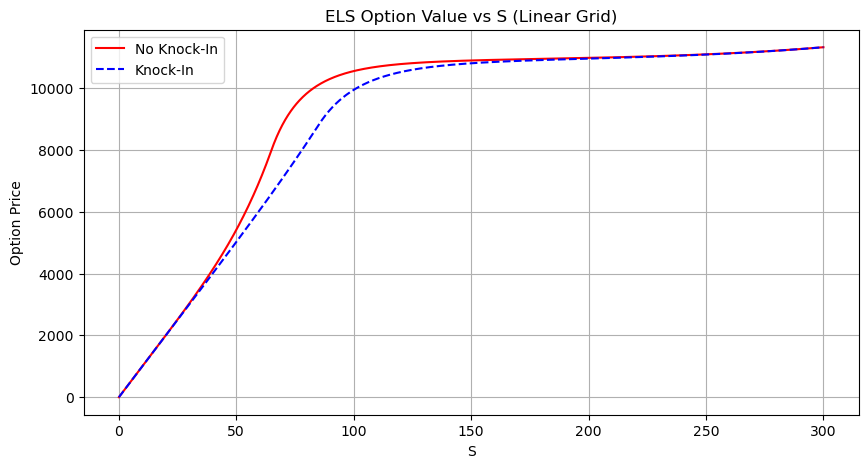

In [15]:
# 환경 초기화로 인한 재정의
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from scipy.interpolate import CubicSpline

S_max = S0 * 3
S_min = 0
M = T[-1]
S = np.linspace(S_min, S_max, N+1)
dS = (S_max - S_min) / N
dt = T[-1] / M
S = np.linspace(0, S_max, N+1)

# Coefficients from the derived implicit FDM scheme
j=np.arange(1,N)
Uj= dt * (-0.5 * sigma**2 * j**2 - 0.5 * (r - q) * j)
Mj = 1 + dt * (r + sigma**2 * j**2)
Dj = dt * (-0.5 * sigma**2 * j**2 + 0.5 * (r - q) * j)

# 삼중대각 행렬 구성 (banded 형식)
ab = np.zeros((3, N-1))
ab[0, 1:] = Uj[:-1]     # 위쪽 대각
ab[1, :]  = Mj     # 메인 대각
ab[2, :-1] = Dj[1:]    # 아래쪽 대각

V = np.zeros((M+1, N+1))
KV = np.zeros((M+1, N+1))

# 만기상환일 페이오프
for i in range(N+1):
    if S[i] < barrier * kijun: # Knock In Barrier 아래에 있으면 손실
        V[M, i] = KV[M, i] = (S[i] / kijun) * 10000
    elif S[i] < K[-1] * kijun: # Knock In Barrier 위, 행사가 아래
        V[M, i] = 10000 * (1 + dummy)
        KV[M, i] = (S[i] / kijun) * 10000
    else: # 행사가 이상이면 
        V[M, i] = KV[M, i] = 10000 * (1 + c[-1])

########################################################
#######################################################
#######################################################
i=M-1

Tidx = np.rint(T / dt).astype(int)
tag = len(Tidx) - 2

rhs_V = V[i+1, 1:N].copy()
rhs_KV = KV[i+1, 1:N].copy()

if tag >= 0 and i == Tidx[tag]: # 조기상환 발생
    up_idx = np.min(np.where(S >= kijun * K[tag]))
    V[i, up_idx:] = 10000 * (1 + c[tag])
    KV[i, up_idx:] = 10000 * (1 + c[tag])
    tag -= 1

# 배리어 아래에 해당하는 주가에 대해서
b_idx = np.min(np.where(S >= kijun * barrier))
V[i, :b_idx] = KV[i, :b_idx]

  # 2차 미분이 0인 경계조건을 반영한 rhs 업데이트
rhs_V[0]  -= Dj[0] * (2 * V[i+1, 1] - V[i+1, 2])        # 하단 경계
rhs_V[-1] -= Uj[-1] * (2 * V[i+1, -2] - V[i+1, -3])     # 상단 경계

rhs_KV[0]  -= Dj[0] * (2 * KV[i+1, 1] - KV[i+1, 2])     # Knock-in 버전
rhs_KV[-1] -= Uj[-1] * (2 * KV[i+1, -2] - KV[i+1, -3])

V[i, 1:N] = solve_banded((1, 1), ab, rhs_V)
KV[i, 1:N] = solve_banded((1, 1), ab, rhs_KV)

# solve_banded 이후에 경계조건 명시
V[i, N] = 2 * V[i, N-1] - V[i, N-2]       # 2차 미분 0 경계조건 (S = S_max)
KV[i, N] = 2 * KV[i, N-1] - KV[i, N-2]    # 동일하게

########################################################
#######################################################
#######################################################



plt.figure(figsize=(10, 5))
plt.plot(S, V[i, :], 'r', label='No Knock-In')
plt.plot(S, KV[i, :], 'b--', label='Knock-In')
plt.xlabel('S')
plt.ylabel('Option Price')
plt.legend()
plt.title("ELS Option Value vs S (Linear Grid)")
plt.grid(True)
plt.show()


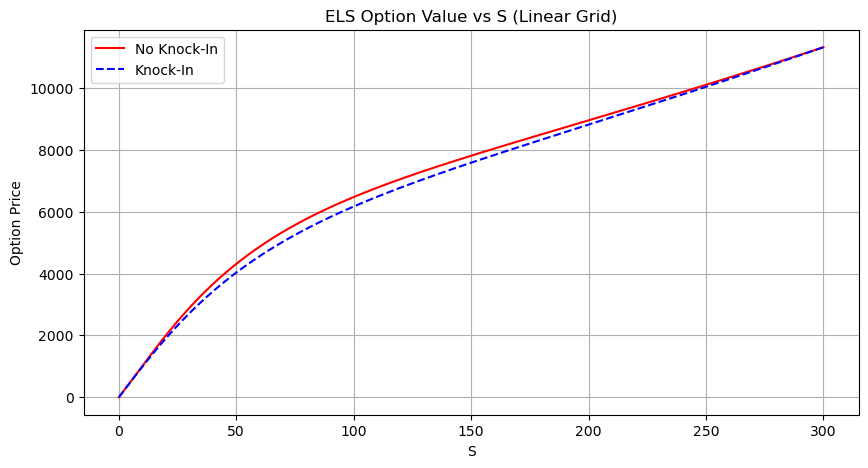

In [25]:
i=i-1

rhs_V = V[i+1, 1:N].copy()
rhs_KV = KV[i+1, 1:N].copy()

if tag >= 0 and i == Tidx[tag]: # 조기상환 발생
    up_idx = np.min(np.where(S >= kijun * K[tag]))
    V[i, up_idx:] = 10000 * (1 + c[tag])
    KV[i, up_idx:] = 10000 * (1 + c[tag])
    tag -= 1

# 배리어 아래에 해당하는 주가에 대해서
b_idx = np.min(np.where(S >= kijun * barrier))
V[i, :b_idx] = KV[i, :b_idx]

  # 2차 미분이 0인 경계조건을 반영한 rhs 업데이트
rhs_V[0]  -= Dj[0] * (2 * V[i+1, 1] - V[i+1, 2])        # 하단 경계
rhs_V[-1] -= Uj[-1] * (2 * V[i+1, -2] - V[i+1, -3])     # 상단 경계

rhs_KV[0]  -= Dj[0] * (2 * KV[i+1, 1] - KV[i+1, 2])     
rhs_KV[-1] -= Uj[-1] * (2 * KV[i+1, -2] - KV[i+1, -3])

V[i, 1:N] = solve_banded((1, 1), ab, rhs_V)
KV[i, 1:N] = solve_banded((1, 1), ab, rhs_KV)

# solve_banded 이후에 경계조건 명시
V[i, 0] = 2 * V[i, 1] - V[i, 2]       # 2차 미분 0 경계조건 (S = S_max)
KV[i, 0] = 2 * KV[i, 1] - KV[i, 2]    # 동일하게
V[i, N] = 2 * V[i, N-1] - V[i, N-2]       # 2차 미분 0 경계조건 (S = S_max)
KV[i, N] = 2 * KV[i, N-1] - KV[i, N-2]    # 동일하게


########################################################
#######################################################
#######################################################



plt.figure(figsize=(10, 5))
plt.plot(S, V[i, :], 'r', label='No Knock-In')
plt.plot(S, KV[i, :], 'b--', label='Knock-In')
plt.xlabel('S')
plt.ylabel('Option Price')
plt.legend()
plt.title("ELS Option Value vs S (Linear Grid)")
plt.grid(True)
plt.show()


In [26]:
i

1098

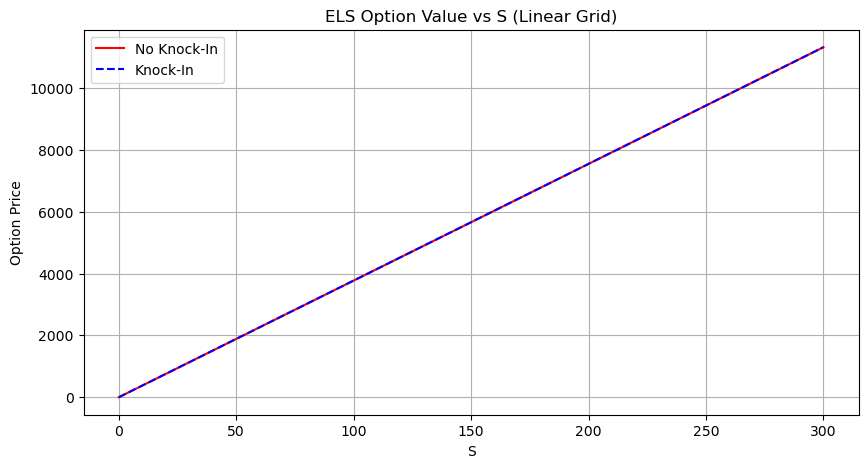

In [13]:
########################################################
#######################################################
#######################################################
# 조기상환일 페이오프(만기일에 가까운 조기상환일부터)
for i in range(M-1,932,-1):
    rhs_V = V[i+1, 1:N].copy()
    rhs_KV = KV[i+1, 1:N].copy()

    if tag >= 0 and i == Tidx[tag]: # 조기상환 발생
        up_idx = np.min(np.where(S >= kijun * K[tag]))
        V[i, up_idx:] = 10000 * (1 + c[tag])
        KV[i, up_idx:] = 10000 * (1 + c[tag])
        tag -= 1

    # 배리어 아래에 해당하는 주가에 대해서
    b_idx = np.min(np.where(S >= kijun * barrier))
    V[i, :b_idx] = KV[i, :b_idx]

      # 2차 미분이 0인 경계조건을 반영한 rhs 업데이트
    rhs_V[0]  -= Dj[0] * (2 * V[i+1, 1] - V[i+1, 2])        # 하단 경계
    rhs_V[-1] -= Uj[-1] * (2 * V[i+1, -2] - V[i+1, -3])     # 상단 경계

    rhs_KV[0]  -= Dj[0] * (2 * KV[i+1, 1] - KV[i+1, 2])     # Knock-in 버전
    rhs_KV[-1] -= Uj[-1] * (2 * KV[i+1, -2] - KV[i+1, -3])

    V[i, 1:N] = solve_banded((1, 1), ab, rhs_V)
    KV[i, 1:N] = solve_banded((1, 1), ab, rhs_KV)

    # solve_banded 이후에 경계조건 명시
    V[i, N] = 2 * V[i, N-1] - V[i, N-2]       # 2차 미분 0 경계조건 (S = S_max)
    KV[i, N] = 2 * KV[i, N-1] - KV[i, N-2]    # 동일하게


########################################################
#######################################################
#######################################################



plt.figure(figsize=(10, 5))
plt.plot(S, V[i, :], 'r', label='No Knock-In')
plt.plot(S, KV[i, :], 'b--', label='Knock-In')
plt.xlabel('S')
plt.ylabel('Option Price')
plt.legend()
plt.title("ELS Option Value vs S (Linear Grid)")
plt.grid(True)
plt.show()


In [14]:
i

933

In [29]:
def SD_1star_FDM(S0, kijun, K, T, c, r, q, sigma, barrier, dummy,N=20000):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.linalg import solve_banded
    from scipy.interpolate import CubicSpline

    S_max = S0 * 3
    S_min = 0
    M = T[-1]
    S = np.linspace(S_min, S_max, N+1)
    dS = (S_max - S_min) / N
    dt = T[-1] / M
    S = np.linspace(S_min, S_max, N+1)

    # Coefficients from the derived implicit FDM scheme
    j=np.arange(1,N)
    Uj= dt * (-0.5 * sigma**2 * j**2 - 0.5 * (r - q) * j)
    Mj = 1 + dt * (r + sigma**2 * j**2)
    Dj = dt * (-0.5 * sigma**2 * j**2 + 0.5 * (r - q) * j)

    # 삼중대각 행렬 구성 (banded 형식)
    ab = np.zeros((3, N-1))
    ab[0, 1:] = Uj[:-1]     # 위쪽 대각
    ab[1, :]  = Mj     # 메인 대각
    ab[2, :-1] = Dj[1:]    # 아래쪽 대각

    V = np.zeros((M+1, N+1))
    KV = np.zeros((M+1, N+1))
    
    # 만기상환일(시간인덱스 M) 페이오프
    for i in range(N+1):
        if S[i] < barrier * kijun: # Knock In Barrier 아래에 있으면 손실
            V[M, i] = KV[M, i] = (S[i] / kijun) * 10000
        elif S[i] < K[-1] * kijun: # Knock In Barrier 위, 행사가 아래
            V[M, i] = 10000 * (1 + dummy)
            KV[M, i] = (S[i] / kijun) * 10000
        else: # 행사가 이상이면 
            V[M, i] = KV[M, i] = 10000 * (1 + c[-1])
    
    # 조기상환일에 해당하는 시간인덱스 지정
    Tidx = np.rint(T / dt).astype(int)
    tag = len(Tidx) - 2 # 마지막에서 2번째 조기상환일

    # 조기상환일 페이오프(만기일 직전 조기상환일)
    for i in reversed(range(M)):
        rhs_V = V[i+1, 1:N].copy()
        rhs_KV = KV[i+1, 1:N].copy()
        
        # 시점 i가 조기상환일이라면
        if tag >= 0 and i == Tidx[tag]:
            # 주가가 조기상환일 위에 있는 최소의 인덱스값 추출
            up_idx = np.min(np.where(S >= kijun * K[tag]))
            # 최소 인덱스이상은 조기상환값으로 대체
            V[i, up_idx:] = 10000 * (1 + c[tag])
            KV[i, up_idx:] = 10000 * (1 + c[tag])
            # 다음 조기상환일로 변경
            tag -= 1
                
        # 배리어 아래에 해당하는 주가에 대해서
        b_idx = np.min(np.where(S >= kijun * barrier))
        V[i, :b_idx] = KV[i, :b_idx]

          # 2차 미분이 0인 경계조건을 반영한 rhs 업데이트
        rhs_V[0]  -= Dj[0] * (2 * V[i+1, 1] - V[i+1, 2])        # 하단 경계
        rhs_V[-1] -= Uj[-1] * (2 * V[i+1, -2] - V[i+1, -3])     # 상단 경계

        rhs_KV[0]  -= Dj[0] * (2 * KV[i+1, 1] - KV[i+1, 2])    # 하단 경계
        rhs_KV[-1] -= Uj[-1] * (2 * KV[i+1, -2] - KV[i+1, -3]) # 상단 경계

        V[i, 1:N] = solve_banded((1, 1), ab, rhs_V)
        KV[i, 1:N] = solve_banded((1, 1), ab, rhs_KV)
        
        # solve_banded 이후에 경계조건 명시(상,한에서의 감마값 0로 세팅)
        V[i, 0] = 2 * V[i, 1] - V[i, 2]       
        KV[i, 0] = 2 * KV[i, 1] - KV[i, 2]    
        V[i, N] = 2 * V[i, N-1] - V[i, N-2]       
        KV[i, N] = 2 * KV[i, N-1] - KV[i, N-2]   

   
    plt.figure(figsize=(10, 5))
    plt.plot(S, V[0, :], 'r', label='No Knock-In')
    plt.plot(S, KV[0, :], 'b--', label='Knock-In')
    plt.xlabel('S')
    plt.ylabel('Option Price')
    plt.legend()
    plt.title("ELS Option Value vs S (Linear Grid)")
    plt.grid(True)
    plt.show()

    C0 = V[0, :]
    option_price = np.interp(S0, S, C0)

    return option_price


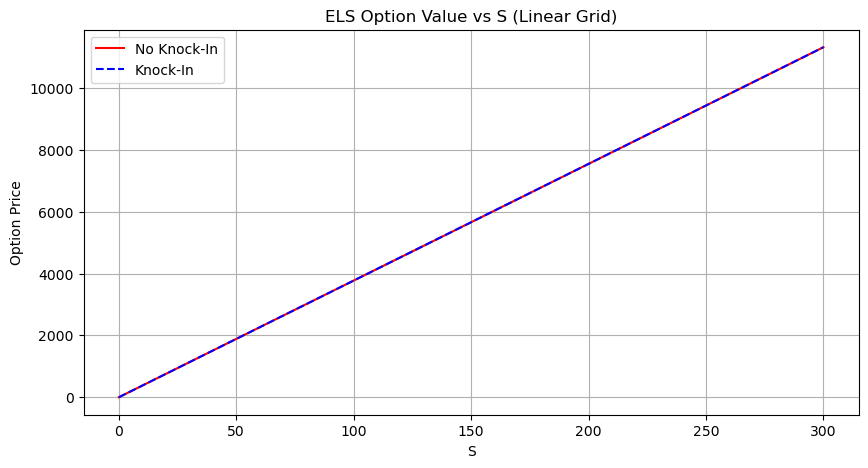

3773.333258267238

In [30]:
SD_1star_FDM(S0, kijun, K, T, c, r, q, sigma, barrier, dummy)